In [1]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from keras.utils import np_utils, to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## create Discriminator
#### parameters of each layers:
  ###### input shape = 32,32,3
  ###### 3 CNN layers
  ###### two outputs = 
  
      dense(1,sigmoid)  : real/fake output
      dense(num_classes,softmax) :class label output
  parameters of each layers:
  - activation function = LeakyRelU
  - batch Normalization 
  - Dropout = 0.5

compile' parameters:
 - optimazer = adam
 - learning rate = 0.0002
 - loss function = binary_crossentropy,sparse_categorical_crossentropy


In [2]:
def define_discriminator(in_shape=(32,32,3), n_classes=10):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=in_shape)
  # normal
  fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(in_image)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # downsample to 8x8
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # normal
  fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # real/fake output
  out1 = Dense(1, activation='sigmoid')(fe)
  # class label output
  out2 = Dense(n_classes, activation='softmax')(fe)
  # define model
  model = Model(in_image, [out1, out2])
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  #model.summary()
  return model


##create Generator
3 transposed CNN

input = latent space dimension = (100,)class size = (10,)

(concatenation of the point in latent space (100 dimensions) and the one hot encoded class label (10 dimensions) that is 110 dimensions.)

This can be achieved by using a learned embedding( 50), 

the input (fully connected layer) :
    
    Dense(num_feature_map,linear activation function)
  parameters of each layers:
  - activation function = relu
  - batch Normalization 
  - padding = same


In [3]:
def define_generator(latent_dim, n_classes=10):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 4 * 4
  li = Dense(n_nodes, kernel_initializer=init)(li)
  # reshape to additional channel
  li = Reshape((4,4, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
  gen = Activation('relu')(gen)
  gen = Reshape((4, 4, 256))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)
  # upsample
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)
  # upsample
  # gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  # gen = BatchNormalization()(gen)
  # gen = Activation('relu')(gen)

  gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  out_layer = Activation('tanh')(gen)
  
  model = Model([in_lat, in_label], out_layer)
  return model

#### CGAN
generator && discriminator

compile' parameter:
- optimizer = adam
- loss function = binary_accuracy, sparse_categorical_crossentropy
- learning rate = 0.0002
- epochs = 100
- batch size = 64

In [4]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  gan_output = d_model(g_model.output)
  model = Model(g_model.input, gan_output)
  
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  return model


## functions:

generate real images,

points in latent space as input for generator

and generate n fake examples, with class labels

In [5]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y






## create 

discriminator, generator, GAN

In [6]:
latent_dim = 100
n_batch = 64
epochs = 100

d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)



In [7]:
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [8]:
g_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4096)         413696      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_2[0][0]                    
____________________________________________________________________________________________

In [9]:
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4096)         413696      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_2[0][0]                    
____________________________________________________________________________________________

## Dataset
download cifar10 data
normalizing Data and change into range  -1 and 1

In [10]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	X_train = np.float32(trainX)
 
	# scale from [0,255] to [-1,1]
	X_train = (X_train / 255 - 0.5) * 2
	X_train = np.clip(X_train, -1, 1)
	#X = (X - 127.5) / 127.5
	return [X_train,trainy]
dataset = load_real_samples()

In [11]:
dataset[0].shape

(50000, 32, 32, 3)

In [12]:
n_steps = int(dataset[0].shape[0] / n_batch)
half_batch = int(n_batch / 2)
d_loss = []
d_g_loss = []
d_loss_label = []
d_g_loss_label = []
for e in range(epochs + 1):
  for i in range(n_steps):

    # get randomly selected 'real' samples
    [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
    # update discriminator model weights
    _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])

    # generate 'fake' examples
    [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    
    # update discriminator model weights
    _,d_f1,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
    #distriminator loss 
    d_loss_batch = 0.5 * (d_r1+ d_f1)
    d_label_batch = 0.5 * (d_r2+ d_f2)

    # prepare points in latent space as input for the generator
    [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
    
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))

    # update the generator via the discriminator's error
    _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
    print('epoch = %d/%d, batch = %d/%d, d_loss=%.3f d_loss_label=%.3f , g_loss=%.3f g_loss_label=%.3f' % (e + 1, epochs, i,n_steps, d_loss_batch,d_label_batch, g_1,g_2),100*' ',end='\r')
     
  d_loss.append(d_loss_batch)
  d_g_loss.append(g_1)
  d_loss_label.append(d_label_batch)
  d_g_loss_label.append(g_2)
  print('epoch = %d/%d, d_loss=%.3f,d_loss_label=%.3f, g_loss=%.3f, g_loss_label=%.3f' % (e + 1, epochs, d_loss[-1], d_loss_label[-1], d_g_loss[-1], d_g_loss_label[-1]), 100*' ')
  if e % 10 == 0:
    samples = 100
    [x_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, samples)
    x_fake = np.clip(x_fake, -1, 1)
    #x_fake = (x_fake + 1) * 127
    #x_fake = np.round(x_fake).astype('uint8')
    plt.figure(figsize=(9,9))
    for k in range(samples):
      plt.subplot(10, 10, k + 1, xticks=[], yticks=[])
      plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))
      plt.title(labels_fake[k])

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### plot loss per each epoch

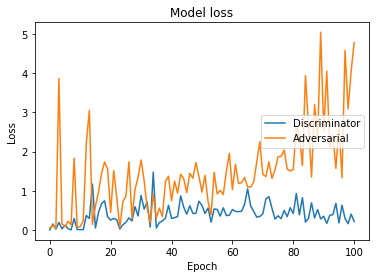

In [13]:
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

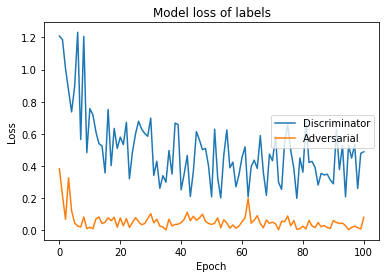

In [14]:
plt.plot(d_loss_label)
plt.plot(d_g_loss_label)
plt.title('Model loss of labels')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()